In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

import time

In [3]:
train_data = datasets.MNIST(
    root = "data",
    download = True,
    train = True,
    transform = ToTensor()    
)
test_data = datasets.MNIST(
    root = "data",
    download = True,
    train = False,
    transform = ToTensor()    
)

In [3]:
def fit(model, train_data, test_data, loss_fn, opti, device):
    model.train()

    ret = []

    total = len(train_data.dataset)
    correct = 0
    loss = 0
    
    for X, y in train_data:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)

        L = loss_fn(y_hat, y)
        loss += L.item()
        L.backward()
        correct += (y_hat.argmax(1) == y).type(torch.float).sum().item()

        opti.step()
        opti.zero_grad()
    loss /= len(train_data)
    ret.extend([loss, correct/total*100])

    model.eval()

    total = len(test_data.dataset)
    correct = 0
    loss = 0

    with torch.no_grad():   
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)

            L = loss_fn(y_hat, y)
            loss += L.item()
            correct += (y_hat.argmax(1) == y).type(torch.float).sum().item()

    loss /= len(test_data)
    ret.extend([loss, correct/total*100])

    return ret

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convStack = nn.Sequential(
            nn.Conv2d(1, 16, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.FC = nn.Sequential(
            nn.Linear(32 * 12 * 12,1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax()
        )
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.convStack(x)
        x = self.flat(x)
        x = self.FC(x)
        return x


device = "cuda"
model = Model().to(device)
print(model)

Model(
  (convStack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
)


In [5]:
results = []

In [7]:
batch_size = 2048
epochs = 450
leraning_rate = 1e-1

train_data_loader = DataLoader(train_data, batch_size=batch_size)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr = leraning_rate)


for _ in range(epochs):
    s = time.time()
    results.append(fit(model,train_data_loader, test_data_loader, loss_fn, opti, device))
    e = time.time()
    e = round(e - s, 3)
    print(_, results[-1], e)
results = np.array(results)

0 [2.3023959477742513, 14.875, 2.302357721328735, 14.580000000000002] 10.82
1 [2.3023164669672647, 13.485, 2.302277755737305, 12.22] 10.509
2 [2.3022384881973266, 11.611666666666668, 2.3021982669830323, 10.95] 10.591
3 [2.302160040537516, 10.731666666666667, 2.3021171569824217, 10.31] 10.646
4 [2.302078644434611, 10.514999999999999, 2.3020320415496824, 10.83] 11.674
5 [2.3019924561182656, 14.280000000000001, 2.3019408226013183, 17.419999999999998] 11.734
6 [2.3018993775049847, 19.346666666666668, 2.301841306686401, 20.74] 11.514
7 [2.301797310511271, 20.863333333333333, 2.301731586456299, 20.93] 11.474
8 [2.3016839106877645, 20.605, 2.3016092777252197, 20.48] 11.5
9 [2.301556913057963, 20.006666666666668, 2.3014711856842043, 19.93] 11.665
10 [2.3014129002889, 19.365, 2.301313591003418, 19.42] 11.606
11 [2.3012471437454223, 18.938333333333333, 2.3011308193206785, 19.02] 12.068
12 [2.30105295976003, 18.638333333333335, 2.3009149074554442, 18.85] 11.825
13 [2.3008215030034385, 18.49000000

KeyboardInterrupt: 

In [9]:
results = np.array(results)

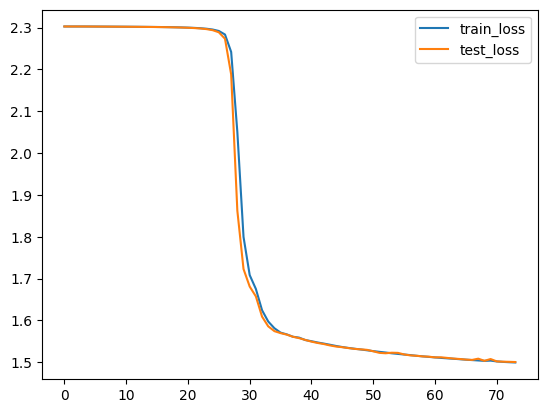

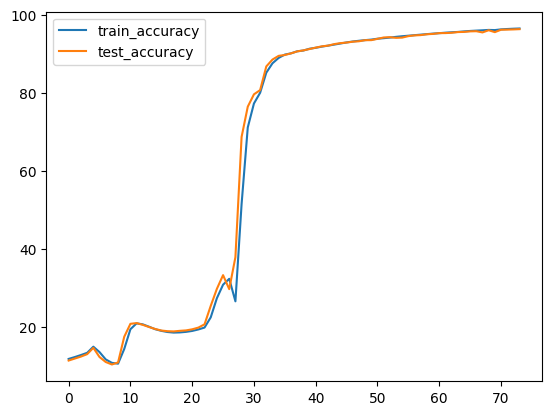

In [10]:
plt.plot(results[:,0], label = "train_loss")
plt.plot(results[:,2], label = "test_loss")
plt.legend()
plt.show()

plt.plot(results[:,1], label = "train_accuracy")
plt.plot(results[:,3], label = "test_accuracy")
plt.legend()
plt.show()

In [11]:
results[-5:]

array([[ 1.50378807, 96.09833333,  1.50752225, 95.57      ],
       [ 1.50181304, 96.285     ,  1.50189199, 96.19      ],
       [ 1.50073489, 96.375     ,  1.50122743, 96.22      ],
       [ 1.49994986, 96.45166667,  1.50089152, 96.27      ],
       [ 1.49932373, 96.51166667,  1.50041394, 96.34      ]])

In [30]:
def random_test(model, i):
    img, label = test_data[i]
    img = torch.reshape(img, (1,1,28,28))
    img = img.to("cuda")
    with torch.no_grad():
        pred = model(img)
        # print(pred)
        print(pred.argmax(axis=1).item(), label)
random_test(model, 5410)

5 5


In [39]:
total_params = 0
for p in model.parameters():
    print(p.shape, p.numel())
    total_params += p.numel()
print(total_params)

torch.Size([16, 1, 3, 3]) 144
torch.Size([16]) 16
torch.Size([32, 16, 3, 3]) 4608
torch.Size([32]) 32
torch.Size([1024, 4608]) 4718592
torch.Size([1024]) 1024
torch.Size([128, 1024]) 131072
torch.Size([128]) 128
torch.Size([10, 128]) 1280
torch.Size([10]) 10
4856906


In [41]:
len(test_data)

10000

In [42]:
torch.save(model, "CNN_BIG.pth")